# Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fast')
import sklearn
import numpy as np

# Data Preparation

### Load data

In [2]:
month1 = pd.read_csv('../Project_data/yellow_tripdata_2019-01.csv')

In [17]:
zone=pd.read_csv('../Project_data/taxi+_zone_lookup.csv')
categories = list(zone)

### Fill in missing values

In [3]:
month1['congestion_surcharge'] = month1['congestion_surcharge'].fillna(0)

### Add columns

#### -Handle date-time format & add year, month, date, hour columns

In [4]:
month1['tpep_pickup_datetime'] = pd.to_datetime(month1['tpep_pickup_datetime']) #%%change to date format
month1.loc[:, 'tpep_pickup_date'] = month1['tpep_pickup_datetime'].dt.date
month1.loc[:, 'tpep_pickup_hour'] = month1['tpep_pickup_datetime'].dt.hour

month1['tpep_dropoff_datetime'] = pd.to_datetime(month1['tpep_dropoff_datetime'])
month1.loc[:, 'tpep_dropoff_hour'] = month1['tpep_dropoff_datetime'].dt.hour
month1.loc[:, 'tpep_pickup_year'] = month1['tpep_pickup_datetime'].dt.year
month1.loc[:, 'tpep_pickup_month'] = month1['tpep_pickup_datetime'].dt.month

#### -Trip duration (second)

In [5]:
#%% calculate difference between time, unit = seconds
month1['trip_duration'] = (month1['tpep_dropoff_datetime'] - month1['tpep_pickup_datetime']).dt.total_seconds()

#### -Average speed (mile/hour)

In [6]:
month1['average_speed'] = (month1['trip_distance']/month1['trip_duration']*3600)

### Handle outliers

#### -Total amount, fare amount, tip amount, extra expense

In [7]:
#%% Drop negative & too high total_amount
#%% inplace: make changes to the original dataset
#%% and,or,not : &|~
month1.drop(month1[(month1['total_amount']<=0)|(month1['total_amount']>100)].index, inplace=True)
month1.drop(month1[(month1['fare_amount']<=0)|(month1['fare_amount']>100)].index,inplace=True)
month1.drop(month1[month1['tip_amount']>60].index,inplace=True)
month1.drop(month1[month1['extra']<0].index,inplace=True)

#### -Trip distance

In [8]:
month1.drop(month1[(month1['trip_distance']>200)|(month1['trip_distance']<0.1)].index,inplace=True)

#### -Month of trip

In [9]:
# Eliminate trips out of 2019.01
month1 = month1[(month1.tpep_pickup_month==1)&(month1.tpep_pickup_year==2019)]

#### -Trip duration

In [10]:
# Eliminate trips lasting for more than 3 hours or less than 1 minute
month1.drop(month1[(month1['trip_duration']>10000)|(month1['trip_duration']<60)].index,inplace=True)

#### -Average speed

In [11]:
month1.drop(month1[month1['average_speed']>100].index,inplace=True)

# Explanatory Data Analysis

### Date and hour distribution (count)

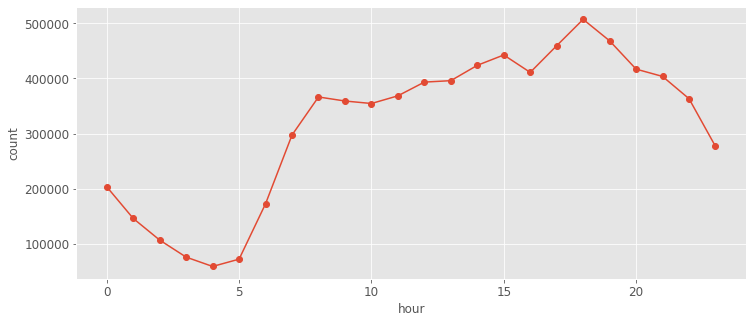

In [12]:
# hour
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 5)
plt.plot(month1.groupby('tpep_pickup_hour').extra.count(), 'o-')
plt.xlabel('hour')
plt.ylabel('count')
plt.xticks(size=12)
plt.yticks(size=12)
plt.show() 

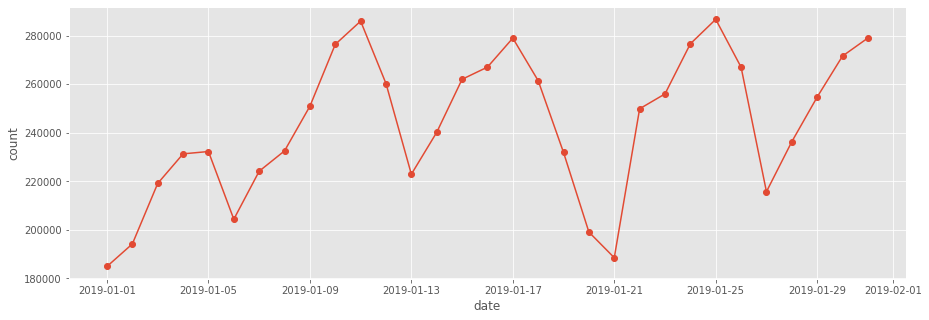

In [13]:
# date
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.plot(month1.groupby('tpep_pickup_date').extra.count(), 'o-') 
plt.xlabel('date')
plt.ylabel('count')
plt.show()

### Distribution of payment & fees

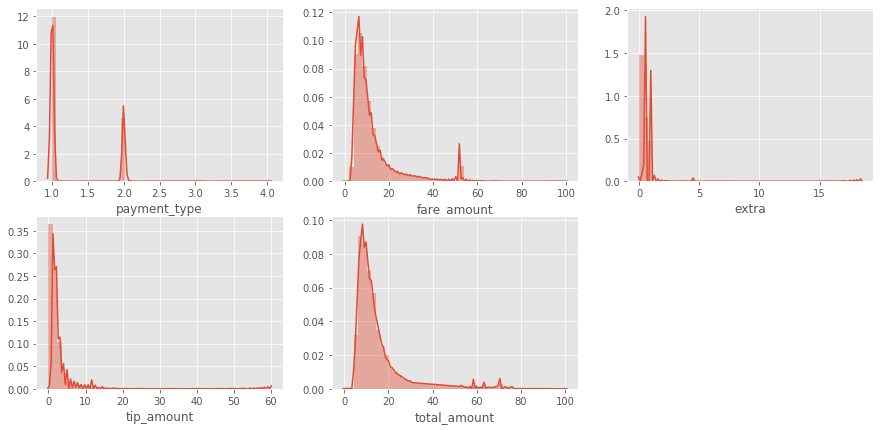

In [14]:
plt.style.use('fast')
plt.rcParams['figure.figsize'] = (15, 7)

plt.subplot(2,3,1)
sns.distplot(month1['payment_type'])

plt.subplot(2,3,2)
sns.distplot(month1['fare_amount'])

plt.subplot(2,3,3)
sns.distplot(month1['extra'])


plt.subplot(2,3,4)
sns.distplot(month1['tip_amount'])

plt.subplot(2,3,5)
sns.distplot(month1['total_amount'])


### Distribution of other variables

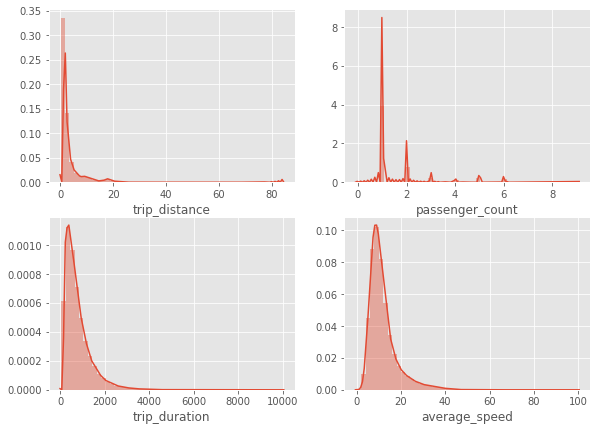

In [15]:
# general distribution
plt.rcParams['figure.figsize'] = (15, 7)
plt.subplot(2,3,1)
sns.distplot(month1['trip_distance'])

plt.subplot(2,3,2)
sns.distplot(month1['passenger_count'])

plt.subplot(2,3,4)
sns.distplot(month1['trip_duration'][month1['trip_duration']<10000])

plt.subplot(2,3,5)
sns.distplot(month1['average_speed'])

### Correlation among all the variables

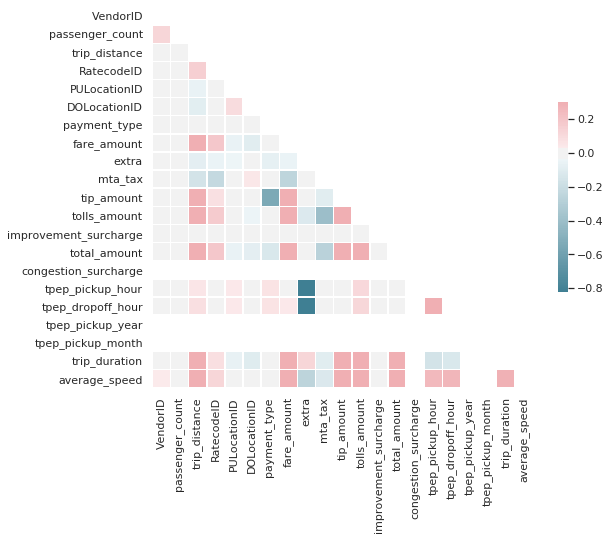

In [18]:
sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = month1[0:100000]
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Influence of multiple variables on "Trip distance" & "Trip duration"

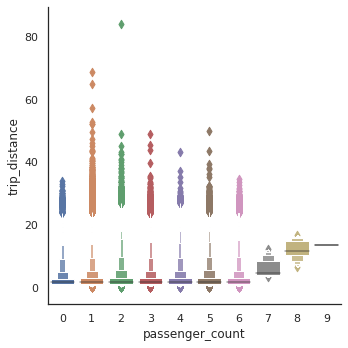

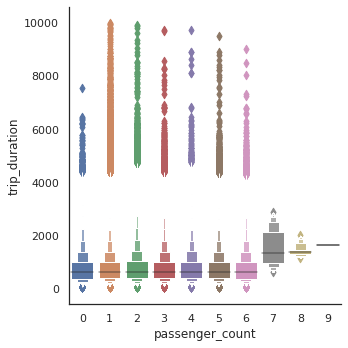

In [21]:
# influence of passenger count
sns.catplot('passenger_count','trip_distance',data=month1,kind='boxen')

sns.catplot('passenger_count','trip_duration',data=month1,kind='boxen')

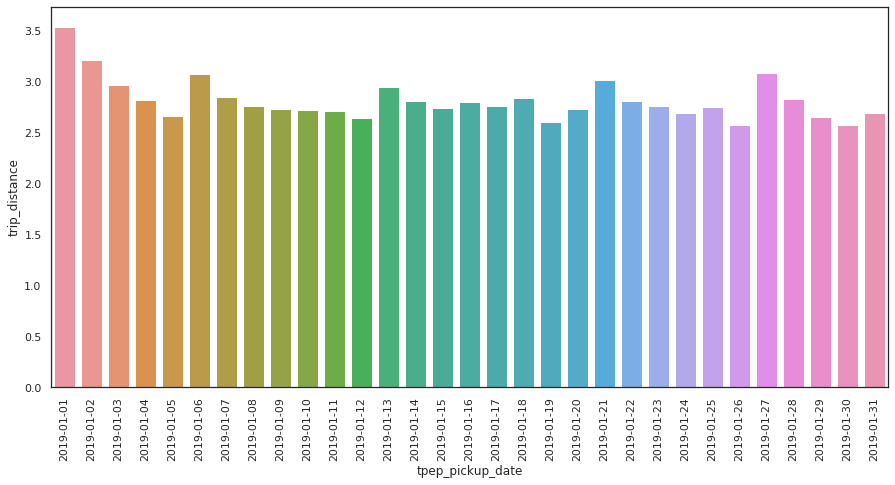

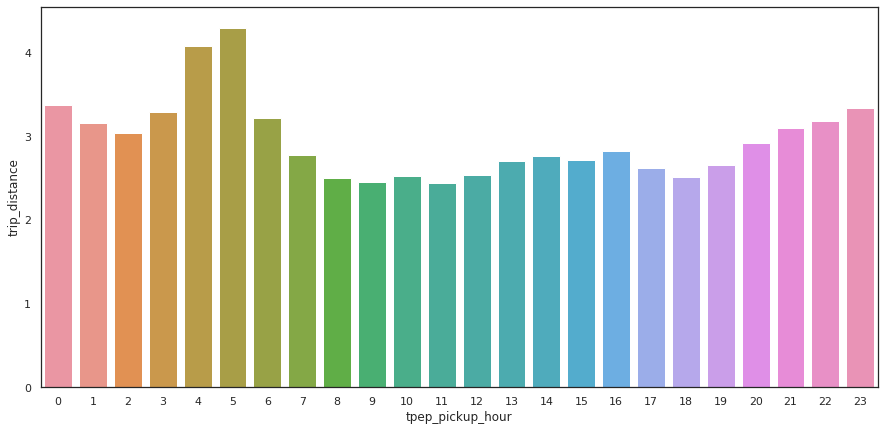

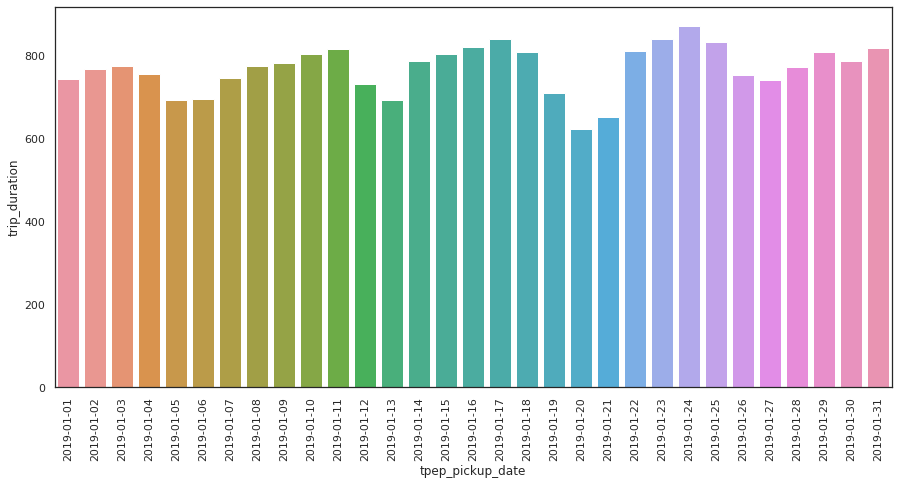

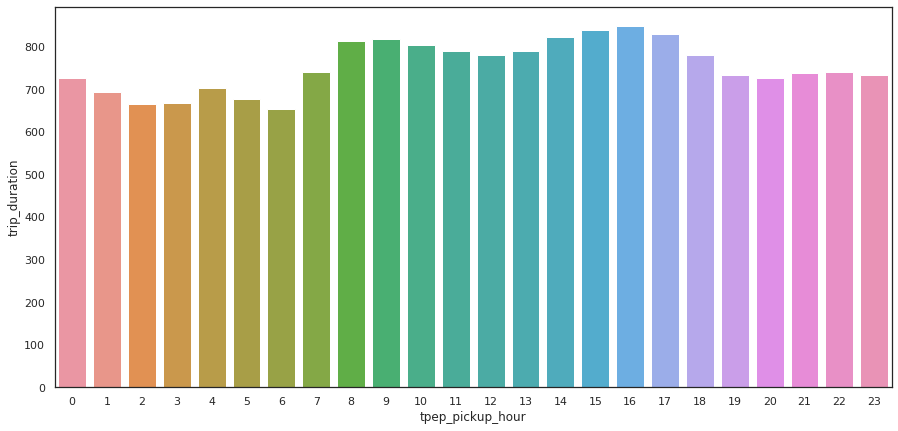

In [22]:
# influence of date&hour
month1_tpd = month1.sort_values('tpep_pickup_date',inplace=False)

sns.barplot('tpep_pickup_date','trip_distance',capsize=3,errwidth=0,data=month1_tpd)
plt.xticks(rotation = 90) #%%flip the xlabel
plt.show()

sns.barplot('tpep_pickup_hour','trip_distance',capsize=3,errwidth=0,data=month1)
plt.show()

sns.barplot('tpep_pickup_date','trip_duration',capsize=3,errwidth=0,data=month1_tpd)
plt.xticks(rotation = 90)
plt.show()

sns.barplot('tpep_pickup_hour','trip_duration',capsize=3,errwidth=0,data=month1)
plt.show()

### Influence of multiple variables on "Average Speed (mile/hour)" → Congestion

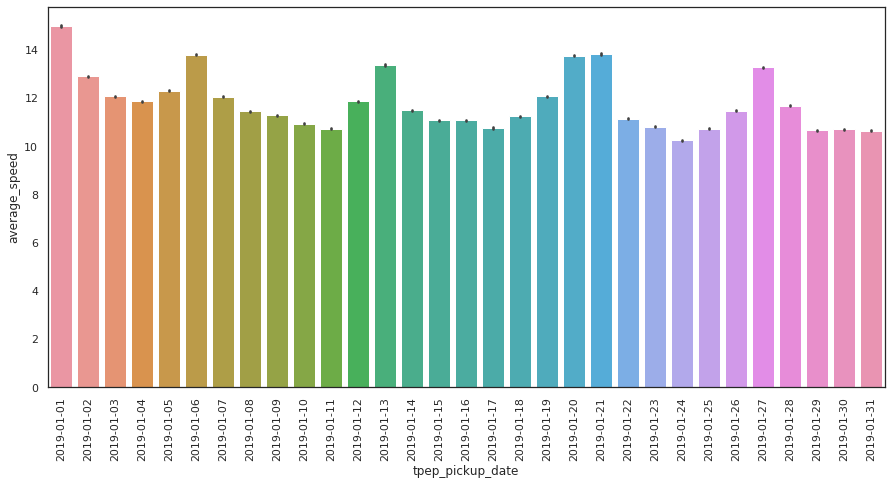

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text xticklabel objects>)

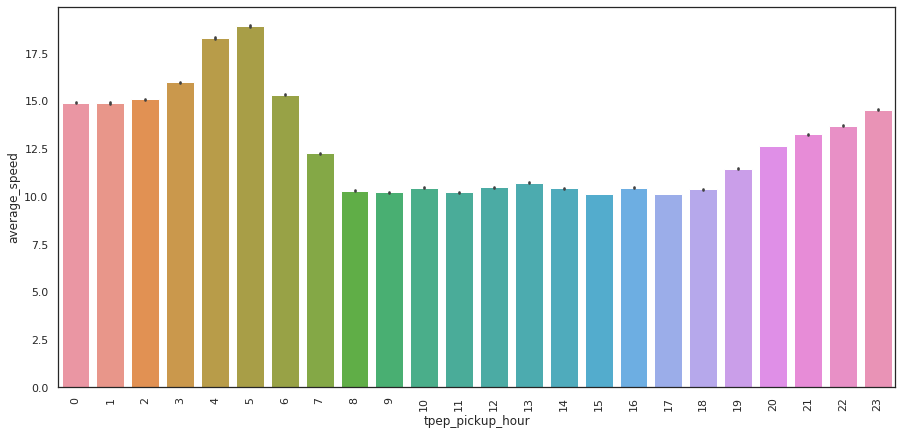

In [23]:
sns.barplot('tpep_pickup_date','average_speed',data=month1_tpd)
plt.xticks(rotation = 90)
plt.show()

sns.barplot('tpep_pickup_hour','average_speed',data=month1_tpd)
plt.xticks(rotation = 90)

# Geographical analysis (Location ID)

In [25]:
month1.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,tpep_pickup_date,tpep_pickup_hour,tpep_dropoff_hour,tpep_pickup_year,tpep_pickup_month,trip_duration,average_speed
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,...,0.3,9.95,0.0,2019-01-01,0,0,2019,1,400.0,13.500000
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,...,0.3,16.30,0.0,2019-01-01,0,1,2019,1,1152.0,8.125000
7,1,2019-01-01 00:21:28,2019-01-01 00:28:37,1,1.3,1,N,163,229,1,...,0.3,9.05,0.0,2019-01-01,0,0,2019,1,429.0,10.909091
8,1,2019-01-01 00:32:01,2019-01-01 00:45:39,1,3.7,1,N,229,7,1,...,0.3,18.50,0.0,2019-01-01,0,0,2019,1,818.0,16.283619
9,1,2019-01-01 00:57:32,2019-01-01 01:09:32,2,2.1,1,N,141,234,1,...,0.3,13.00,0.0,2019-01-01,0,1,2019,1,720.0,10.500000


### Count distribution

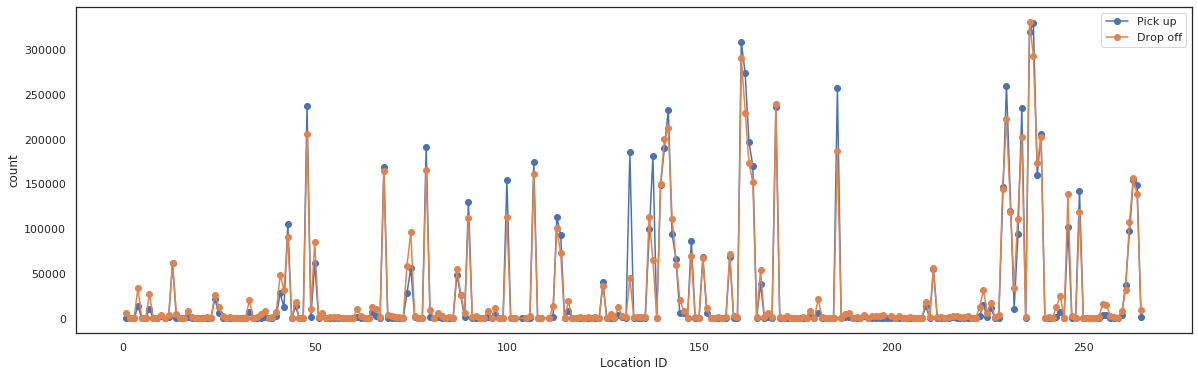

In [26]:
plt.rcParams['figure.figsize'] = (20, 6)
plt.plot(month1.groupby('PULocationID').extra.count(), 'o-',label='Pick up') 
plt.plot(month1.groupby('DOLocationID').extra.count(), 'o-',label='Drop off')
plt.xlabel('Location ID')
plt.ylabel('count')
plt.legend()
plt.show()

### Trip distance

Text(0, 0.5, 'trip duration')

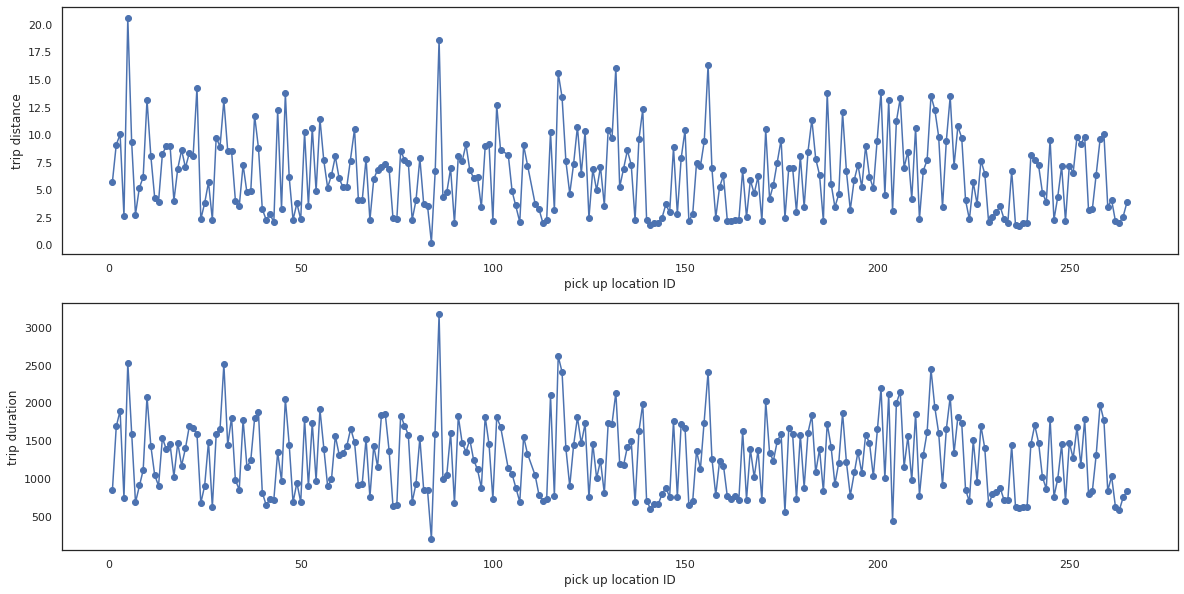

In [27]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.subplot(211)
plt.plot(month1.groupby('PULocationID').trip_distance.mean(), 'o-') 
plt.xlabel('pick up location ID')
plt.ylabel('trip distance')

plt.subplot(212)
plt.plot(month1.groupby('PULocationID').trip_duration.mean(), 'o-') 
plt.xlabel('pick up location ID')
plt.ylabel('trip duration')

### Count & Hour distribution

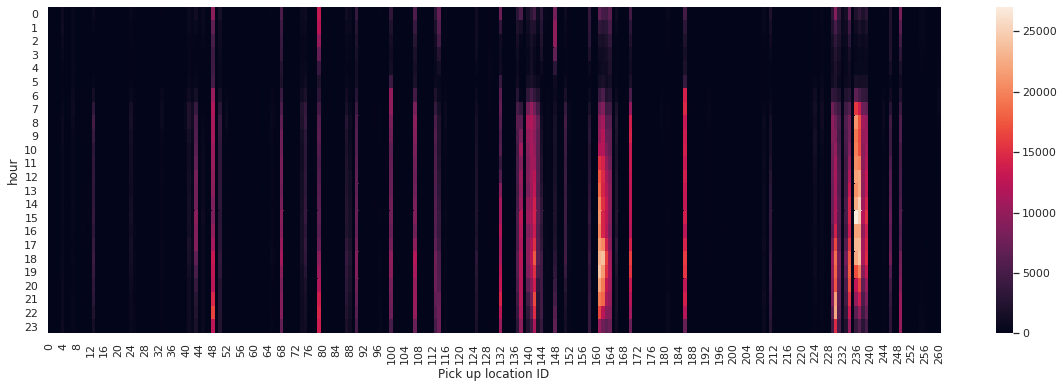

In [28]:
LID_hour = np.zeros((24,261))
for i in range(len(LID_hour)):
    for j in range(len(LID_hour[0])):
        LID_hour[i,j] = month1[(month1['PULocationID']==j)&(month1['tpep_pickup_hour']==i)].extra.count()
plt.rcParams['figure.figsize'] = (20, 6)
sns.heatmap(LID_hour,label='count')
plt.xlabel('Pick up location ID')
plt.ylabel('hour')
plt.savefig('heatmap.jpg')
plt.show()

#LID_hour = np.zeros((24,261))
#for i in range(len(LID_hour)):
#    for j in range(len(LID_hour[0])):
#        LID_hour[i,j] = month1_[(month1_['DOLocationID']==j)&(month1_['tpep_dropoff_hour']==i)].extra.count()
#plt.rcParams['figure.figsize'] = (20, 6)
#sns.heatmap(LID_hour)
#plt.xlabel('Drop off location ID')
#plt.ylabel('hour')
#plt.show()

### Average speed & hour distribution

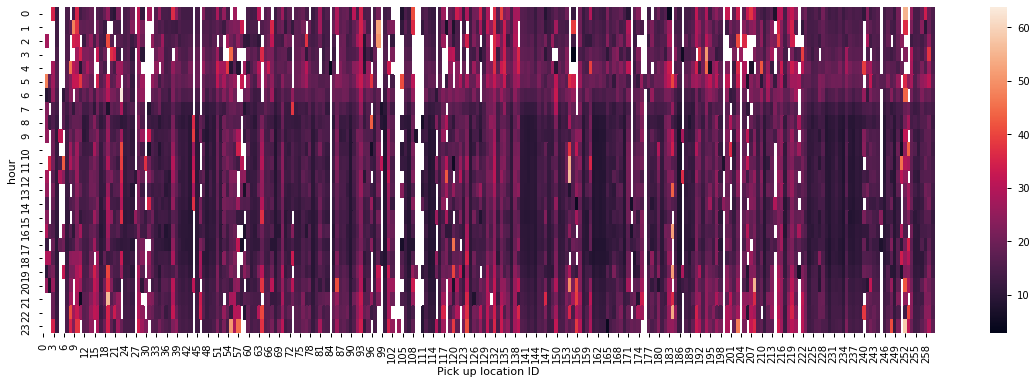

In [119]:
LID_hour_as = np.zeros((24,261))
for i in range(len(LID_hour)):
    for j in range(len(LID_hour[0])):
        LID_hour_as[i,j] = month1[(month1['PULocationID']==j)&(month1['tpep_pickup_hour']==i)].average_speed.mean()
plt.rcParams['figure.figsize'] = (20, 6)
sns.heatmap(LID_hour_as)
plt.xlabel('Pick up location ID')
plt.ylabel('hour')
plt.show()

# Fare Prediction Model

In [29]:
month1.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,tpep_pickup_date,tpep_pickup_hour,tpep_dropoff_hour,tpep_pickup_year,tpep_pickup_month,trip_duration,average_speed
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,...,0.3,9.95,0.0,2019-01-01,0,0,2019,1,400.0,13.500000
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,...,0.3,16.30,0.0,2019-01-01,0,1,2019,1,1152.0,8.125000
7,1,2019-01-01 00:21:28,2019-01-01 00:28:37,1,1.3,1,N,163,229,1,...,0.3,9.05,0.0,2019-01-01,0,0,2019,1,429.0,10.909091
8,1,2019-01-01 00:32:01,2019-01-01 00:45:39,1,3.7,1,N,229,7,1,...,0.3,18.50,0.0,2019-01-01,0,0,2019,1,818.0,16.283619
9,1,2019-01-01 00:57:32,2019-01-01 01:09:32,2,2.1,1,N,141,234,1,...,0.3,13.00,0.0,2019-01-01,0,1,2019,1,720.0,10.500000


### Preperation

In [31]:
col_n = ['trip_distance','trip_duration','DOLocationID','average_speed','PULocationID','tpep_pickup_hour']

x = pd.DataFrame(month1,columns = col_n) #%%choose some columns
y = month1['total_amount'].values

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 45)

from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
x_train = mm.fit_transform(x_train)
x_test = mm.transform(x_test)

### Random Forest - model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(max_depth=20,min_samples_leaf=4)

model_rf.fit(x_train,y_train)
y_pred = model_rf.predict(x_test)

print("Training score=", model_rf.score(x_train, y_train))
print("Testing score=", model_rf.score(x_test, y_test))


### Random Forest - result

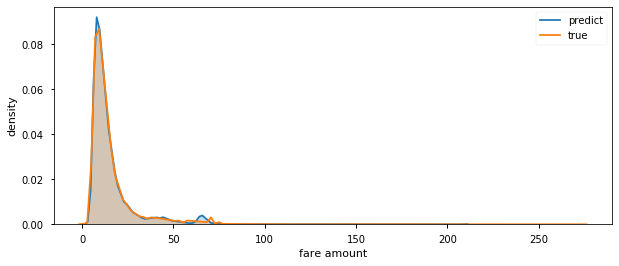

In [123]:
plt.rcParams['figure.figsize'] = (10, 4)
sns.distplot(y_pred,label='predict',hist=False,kde_kws={"shade": True})
sns.distplot(y,label='true',hist=False,kde_kws={"shade": True})
plt.xlabel('fare amount')
plt.ylabel('density')
plt.legend()

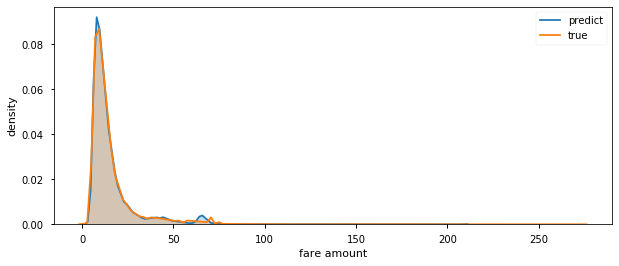

In [123]:
plt.rcParams['figure.figsize'] = (10, 4)
sns.distplot(y_pred,label='predict',hist=False,kde_kws={"shade": True})
sns.distplot(y,label='true',hist=False,kde_kws={"shade": True})
plt.xlabel('fare amount')
plt.ylabel('density')
plt.legend()

Text(0, 0.5, 'feature importance')

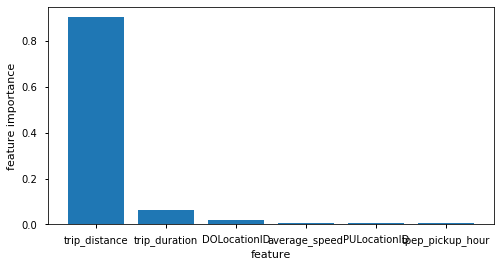

In [124]:
feature_importances = dict(zip(x.columns, model_rf.feature_importances_))
sorted(feature_importances.items(), key=lambda item: item[1])

plt.rcParams['figure.figsize'] = (8, 4)
fi_x = feature_importances.keys()
fi_y = feature_importances.values()
plt.bar(fi_x,fi_y)
plt.xlabel('feature')
plt.ylabel('feature importance')

### SVM

In [ ]:
from sklearn.svm import SVR
model_svr = SVR()

model_svr.fit(x_train,y_train)

y_pred = model_svr.predict(x_test)
print("Training score=", model_svr.score(x_train, y_train))
print("Testing score=", model_svr.score(x_test, y_test))